# Data Cleaning & Initial Exploration

Table of Contents

1. [Initiation](#initiation) <br>
2. [Operational logs and ship classes](#operationallogs)<br>
    2.1. [First look](#firstlook)<br>
    2.2. [Unallowed passages](#unallowedpassages)<br>
    2.3. [Passages and renovation](#passagesrenovation)<br>
    2.4. [Observing trends in ship class characteristics](#observingtrends)<br>
    2.5. [Passage times](#passagetimes)<br>
    2.6. [Lockages](#lockages)<br>
3. [Malfunctions](#malfunctions)<br>

<a id='initiation'></a>
## 1. Initiation

Let's start by importing necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import DateFormatter
hh_mm = DateFormatter('%H:%M')
from tqdm import tqdm
from datetime import timedelta
plt.rcParams["font.family"] = "Times New Roman"
from scipy import stats
from sklearn import cluster
np.random.seed(0)
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn.linear_model import LinearRegression
os.environ["OMP_NUM_THREADS"] = "1" 
viridis_colors=['#440154FF', '#414487FF', '#22A884FF', '#7AD151FF', '#FDE725FF']
viridis_colors_6=['#440154', '#414487', '#2a788e', '#22a884', '#7ad151', '#fde725'] 

Below are a few useful functions that are used in the following sections.

In [2]:
from googletrans import Translator # for translations from Dutch
translator = Translator()

# Inspired from https://www.thepythoncode.com/article/translate-text-in-python?utm_content=cmp-true
def english_translation(text, full_form=False, source="nl", destination="en"):
    """
    This function aims to make the translation task less repetitive.
    
    Arguments
    ---------
    text             : string
                    Text to be translated
                    
    full_form       : Boolean
                    Whether the returned format is full form (including the original, 
                    code for destination language and the translation) or only the translation
                    
    source           : string
                    Language code for the source language. Full list of codes for available languages
                    can be found in the following link:
                    https://buildmedia.readthedocs.org/media/pdf/py-googletrans/latest/py-googletrans.pdf

    destination      : string
                    Language code for the destination language.                

    Returns
    -------
    translation_text : string
                    Translation, in full form or only the final translated text
    
    """
    if(type(text)==str):
        translation = translator.translate(text, src= source, dest=destination)
        translation_text = f"{translation.origin} ({destination}: {translation.text})" if full_form else f"{translation.text}"
        return translation_text
    else:
        return text

# Let's test it:
english_translation("Hallo Wereld!")

'Hello World!'

In [3]:
def report_unique_values(df, col_list= [], translate= False):
    """
    This function reports number of unique values observed, prints the first five 
    and returns a dictionary with unique values for given columns as well as a list 
    of column names where there is only 1 unique value.
    
    Arguments
    ---------
    df             : pd.DataFrame
                    Dataframe for which unique values are to be reported
                    
    col_list       : (optional) string list
                    List of columns for which reporting is desired
    
    translate       : Boolean
                    Whether the string values are to be translated in English while reporting                
    
                    
    Returns
    -------
    unique_values   : dict
                    Dictionary where unique values are stored per column of interest
    
    cols_with_one_unique    : list
                    List of columns where only 1 unique value is observed
                            
                    
    
    """
    unique_values = {}
    cols_with_one_unique = []
    for col_name in col_list:
        unique_values[col_name]= df[col_name].unique()
        print(
            f'*** {col_name} has {len(unique_values[col_name])} unique value(s): ', 
            f'{[english_translation(x, full_form=True) if translate else x for x in unique_values[col_name][:5]]}',
            f'and {len(unique_values[col_name]) - 5} more' if len(unique_values[col_name])> 5 else ''
        )
        if(len(unique_values[col_name]) == 1):
            cols_with_one_unique.append(col_name)
    
    return unique_values, cols_with_one_unique

In [4]:
# adapted from https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/
def find_outliers_IQR(df, multiplier = 1.5):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-multiplier*IQR)) | (df>(q3+multiplier*IQR)))]
   return outliers

def eliminate_outliers_IQR(df, multiplier = 1.5):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers_eliminated = df[((df>(q1-multiplier*IQR)) & (df<(q3+multiplier*IQR)))]
   return outliers_eliminated

In [5]:
def formalize_string(text):
    """
    This function formats the text so that it is more formal
    
    Arguments
    ---------
    text             : string
                    Text to be formalized
                    
    Returns
    -------
    formalized_text   : string
                    Formalized text
                            
                    
    
    """
    formalized_text = text.replace("_"," ").title()
    return formalized_text

#Let's test it
formalize_string("test_it_for_me")

'Test It For Me'

In [6]:
def plot_scatter_of_pair(df, col_1, col_2, save_plt_path="", formalize=True, figsize=(10, 8)):
    """
    This function plots the 
    
    Arguments
    ---------
    df             : pd.DataFrame
                    Dataframe for which unique values are to be reported
                    
    col_1       :   string
                    Column name of the first element of the pair

    col_2       :   string
                    Column name of the second element of the pair
    
    formalize   :   boolean
                    Whether the axis titles are to be formalized
                    

    Returns
    -------
    pair_summary : 
                            
    """
    
    pair_summary = df.groupby([col_1, col_2], as_index= False).size()
    fig, ax = plt.subplots(figsize=figsize)
    

    scatter = ax.scatter(data=pair_summary, x=col_1, y=col_2, c="size")
    ax.set_xlabel(formalize_string(col_1))
    ax.set_ylabel(formalize_string(col_2))
    # ax.set_title(f"Observation frequency for {formalize_string(col_1)} and {formalize_string(col_2)} pairs")
    
    if formalize_string(col_1)=='Year':
        ax.set_xticks(df[col_1].unique())

    # produce a legend with colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(), loc="center left", bbox_to_anchor=(1, 0.5), ncols=1,
                        title="Number of observations")
    
    ax.add_artist(legend1)
    plt.tight_layout()
    
    if save_plt_path!="":
        plt.savefig(save_plt_path, bbox_extra_artists=(legend1,), bbox_inches='tight')
    plt.show()

    return pair_summary

<a id='operationallogs'></a>
## 2. Operational logs and ship classes

<a id='firstlook'></a>
### 2.1. First look

Operational log data was received in .xlsx format from RWS upon request. It concerns the passages through Volkerak locks from 2018 to 2022.
Now, time to read the excel file. Inspecting the first 5 rows can give us an idea about the structure.

In [7]:
passages =  pd.read_csv("data/passages_matched.csv")
renaming_dict = {
    "IOL_TRAJECT_CD": "iol_traject_cd",
    "IO_NAAM": "io_name",
    "v03_Evenement": "event_id",
    "Evenementomschrijving": "event_description",
    "v05_06_Begindt_evenement": "event_start",
    "v07_Duur_van_evenement": "event_duration",
    "v10_1_Kolk": "chamber_id",
    "Kolknaam": "chamber_name",
    "v12_Vaarrichting": "direction_id",
    "Vaarrichtingomschrijving": "direction",
    "v15_1_Scheepstype_RWS": "ship_type",
    "SK_CODE": "sk_code",
    "Jaar": "year",
    "Maand": "month",
    "Dag": "day",
    "Uur": "hour",
    "SK_ShipType": "sk_shiptype",
    "SIVAK_class": "sivak_class"
}

passages.rename(columns=renaming_dict, inplace=True)
passages.event_start= pd.to_datetime(passages.event_start)
passages['event_end'] = passages.apply(lambda x: x['event_start'] + timedelta(minutes=x['event_duration']), axis=1)
passages.head()

,iol_traject_cd,io_name,event_id,event_description,event_start,event_duration,chamber_id,chamber_name,direction_id,direction,ship_type,sk_code,year,month,day,hour,sk_shiptype,sivak_class
0,Z01VO,Volkeraksluizen,7,Scheepspassage bij een bediende sluis of brug,1-1-2018 0:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,1,0,M8:2,M8 (Groot Rijnschip) (CEMT V)
1,Z01VO,Volkeraksluizen,7,Scheepspassage bij een bediende sluis of brug,1-1-2018 0:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,1,0,M8:2,M8 (Groot Rijnschip) (CEMT V)
2,Z01VO,Volkeraksluizen,7,Scheepspassage bij een bediende sluis of brug,1-1-2018 0:53:00,76,2,Middenkolk Volkeraksluizen,1,Noord,2,M8,2018,1,1,0,M8:2,M8 (Groot Rijnschip) (CEMT V)
3,Z01VO,Volkeraksluizen,7,Scheepspassage bij een bediende sluis of brug,1-1-2018 1:26:00,36,3,Westkolk Volkeraksluizen,3,Zuid,4,M8,2018,1,1,1,M8:4,M8 (Groot Rijnschip) (CEMT V)
4,Z01VO,Volkeraksluizen,7,Scheepspassage bij een bediende sluis of brug,1-1-2018 2:40:00,78,2,Middenkolk Volkeraksluizen,1,Noord,2,M12,2018,1,1,2,M12:2,M12 (Rijnmax)


I'm curious about the unique and missing values in each column. I want to print that information.

In [9]:
passages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545358 entries, 0 to 545357
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   iol_traject_cd     545358 non-null  object        
 1   io_name            545358 non-null  object        
 2   event_id           545358 non-null  int64         
 3   event_description  545358 non-null  object        
 4   event_start        545358 non-null  datetime64[ns]
 5   event_duration     545358 non-null  int64         
 6   chamber_id         545358 non-null  int64         
 7   chamber_name       545358 non-null  object        
 8   direction_id       545358 non-null  int64         
 9   direction          545358 non-null  object        
 10  ship_type          545358 non-null  int64         
 11  sk_code            485033 non-null  object        
 12  year               545358 non-null  int64         
 13  month              545358 non-null  int64   

In [10]:
unique_values, cols_with_one_unique = report_unique_values(passages, passages.columns, True)

*** iol_traject_cd has 1 unique value(s):  ['Z01VO (en: Z01VO)'] 
*** io_name has 1 unique value(s):  ['Volkeraksluizen (en: Volkerak locks)'] 
*** event_id has 1 unique value(s):  [7] 
*** event_description has 1 unique value(s):  ['Scheepspassage bij een bediende sluis of brug (en: Ship passage at an operated lock or bridge)'] 
*** event_start has 219196 unique value(s):  [numpy.datetime64('2018-01-01T00:33:00.000000000'), numpy.datetime64('2018-01-01T00:53:00.000000000'), numpy.datetime64('2018-01-01T01:26:00.000000000'), numpy.datetime64('2018-01-01T02:40:00.000000000'), numpy.datetime64('2018-01-01T02:31:00.000000000')] and 219191 more
*** event_duration has 342 unique value(s):  [53, 76, 36, 78, 29] and 337 more
*** chamber_id has 4 unique value(s):  [3, 2, 1, 4] 
*** chamber_name has 4 unique value(s):  ['Westkolk Volkeraksluizen (en: Westkolk Volkerak locks)', 'Middenkolk Volkeraksluizen (en: Middle chamber Volkerak locks)', 'Oostkolk Volkeraksluizen (en: Oostkolk Volkerak lock

A few immediate observations: 
* There are some columns with only 1 unique value. As these columns do not differentiate from one observation to the other, they don't provide valuable information.
* sk_code column has missing values (count: 60325).
* Not all entries were matched with a sivak code (count: 593). These are entries where ship_type is equal to 0 (Type unknown).

Since those that are not matched constitute a small part of the data (around 1/1000), I will drop them.

In [11]:
print(f"For {round(100*passages['sk_code'].isna().sum()/len(passages),1)}% of the entries ({passages['sk_code'].isna().sum()}), SK code is not available.")
print(f"For {round(100*len(passages[passages['ship_type']==0])/len(passages),1)}% of the entries ({len(passages[passages['ship_type']==0])}), RWS ship type is unknown.")
print(f"For {round(100*passages['sivak_class'].isna().sum()/len(passages),1)}% of the entries ({passages['sivak_class'].isna().sum()}), ship is not matched with a SIVAK class.")

For 11.1% of the entries (60325), SK code is not available.
For 0.1% of the entries (593), RWS ship type is unknown.
For 0.1% of the entries (593), ship is not matched with a SIVAK class.


In [12]:
passages.drop(columns=cols_with_one_unique, inplace=True)
passages.dropna(subset=['sivak_class'], inplace=True)
passages.head()

,event_start,event_duration,chamber_id,chamber_name,direction_id,direction,ship_type,sk_code,year,month,day,hour,sk_shiptype,sivak_class,event_end
0,2018-01-01 00:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,1,0,M8:2,M8 (Groot Rijnschip) (CEMT V),2018-01-01 01:26:00
1,2018-01-01 00:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,1,0,M8:2,M8 (Groot Rijnschip) (CEMT V),2018-01-01 01:26:00
2,2018-01-01 00:53:00,76,2,Middenkolk Volkeraksluizen,1,Noord,2,M8,2018,1,1,0,M8:2,M8 (Groot Rijnschip) (CEMT V),2018-01-01 02:09:00
3,2018-01-01 01:26:00,36,3,Westkolk Volkeraksluizen,3,Zuid,4,M8,2018,1,1,1,M8:4,M8 (Groot Rijnschip) (CEMT V),2018-01-01 02:02:00
4,2018-01-01 02:40:00,78,2,Middenkolk Volkeraksluizen,1,Noord,2,M12,2018,1,1,2,M12:2,M12 (Rijnmax),2018-01-01 03:58:00


In [13]:
sk_ship_codes =  pd.read_csv("data/match_assumptions.csv", index_col=0)
sk_ship_codes_dict = sk_ship_codes.loc[:, ["cargo_type", "cargo_subtype"]].to_dict('index')
sk_ship_codes_dict["M8:2"]

{'cargo_type': 'Tank', 'cargo_subtype': 'Tank'}

In [14]:
ship_classes =  pd.read_csv("data/ship_classes.csv", index_col=0)
ship_classes_dict = ship_classes.set_index('Ship Class').to_dict('index')
ship_classes_dict["M8 (Groot Rijnschip) (CEMT V)"]

{'Ship Type': 'MotorVessel',
 'Chamber': 'commercial',
 'Min Speed (km/h)': 12,
 'Max Speed (km/h)': 20,
 'Min Speed Loaded (km/h)': 10.0,
 'Max Speed Loaded (km/h)': 17,
 'UKC (m)': 0.3,
 'Height Margin (m)': 0.1,
 'Block Coefficient (%)': 80,
 'Engine Power (kW)': 1250,
 'Mean Draft Empty (m)': 0.7,
 'Residual Resistance Coefficient': 0.15,
 'Slowsteaming (%)': 80,
 'DWT': 2831.0,
 'LOA': 106.0,
 'Width': 11.32,
 'Area': 1199.92}

In [15]:
passages['chamber_allowed'] = passages.apply(lambda x: ship_classes_dict[x['sivak_class']]['Chamber'], axis=1)
passages['chamber_check'] = passages.apply(lambda x: 
                                           True if x['chamber_allowed']=='either' 
                                           else(True if x['chamber_allowed']=='recreational' and x['chamber_id'] == 4
                                                else True if x['chamber_allowed']=='commercial' and x['chamber_id'] != 4
                                                else False), axis=1)
passages.head()

,event_start,event_duration,chamber_id,chamber_name,direction_id,direction,ship_type,sk_code,year,month,day,hour,sk_shiptype,sivak_class,event_end,chamber_allowed,chamber_check
0,2018-01-01 00:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,1,0,M8:2,M8 (Groot Rijnschip) (CEMT V),2018-01-01 01:26:00,commercial,True
1,2018-01-01 00:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,1,0,M8:2,M8 (Groot Rijnschip) (CEMT V),2018-01-01 01:26:00,commercial,True
2,2018-01-01 00:53:00,76,2,Middenkolk Volkeraksluizen,1,Noord,2,M8,2018,1,1,0,M8:2,M8 (Groot Rijnschip) (CEMT V),2018-01-01 02:09:00,commercial,True
3,2018-01-01 01:26:00,36,3,Westkolk Volkeraksluizen,3,Zuid,4,M8,2018,1,1,1,M8:4,M8 (Groot Rijnschip) (CEMT V),2018-01-01 02:02:00,commercial,True
4,2018-01-01 02:40:00,78,2,Middenkolk Volkeraksluizen,1,Noord,2,M12,2018,1,1,2,M12:2,M12 (Rijnmax),2018-01-01 03:58:00,commercial,True


In [ ]:
passages.groupby(['chamber_id','chamber_name']).size()

chamber_id  chamber_name                          
1           Oostkolk Volkeraksluizen                  154481
2           Middenkolk Volkeraksluizen                163196
3           Westkolk Volkeraksluizen                  162615
4           Sluiskolk Jachtensluis Volkeraksluizen     64473
dtype: int64

In [ ]:
passages.groupby(['direction_id','direction']).size()

direction_id  direction
1             Noord        268656
3             Zuid         276109
dtype: int64

<a id='unallowedpassages'></a>
### 2.2. Unallowed passages

In [16]:
print(f"{round(100-100*passages[passages['chamber_allowed']=='commercial']['chamber_check'].mean(),1)}% of the commercial vessels " 
      f"({len(passages[(passages['chamber_allowed']=='commercial') & (passages['chamber_check']==False)])}/{len(passages[passages['chamber_allowed']=='commercial'])}) "
      f"go through the recreational chamber."
      )
print(f"{round(100-100*passages[passages['chamber_allowed']=='recreational']['chamber_check'].mean(),1)}% of the recreational vessels " 
      f"({len(passages[(passages['chamber_allowed']=='recreational') & (passages['chamber_check']==False)])}/{len(passages[passages['chamber_allowed']=='recreational'])}) "
      f"go through the commercial chamber."
      )

4.9% of the commercial vessels (24746/501267) go through the recreational chamber.
8.7% of the recreational vessels (3771/43498) go through the commercial chamber.


In [17]:
pivot_table_passages = passages.pivot_table(index=pd.Grouper(key='event_start', freq='Q'), 
                                            columns=['chamber_allowed', 'chamber_check'], aggfunc='size').fillna(0)

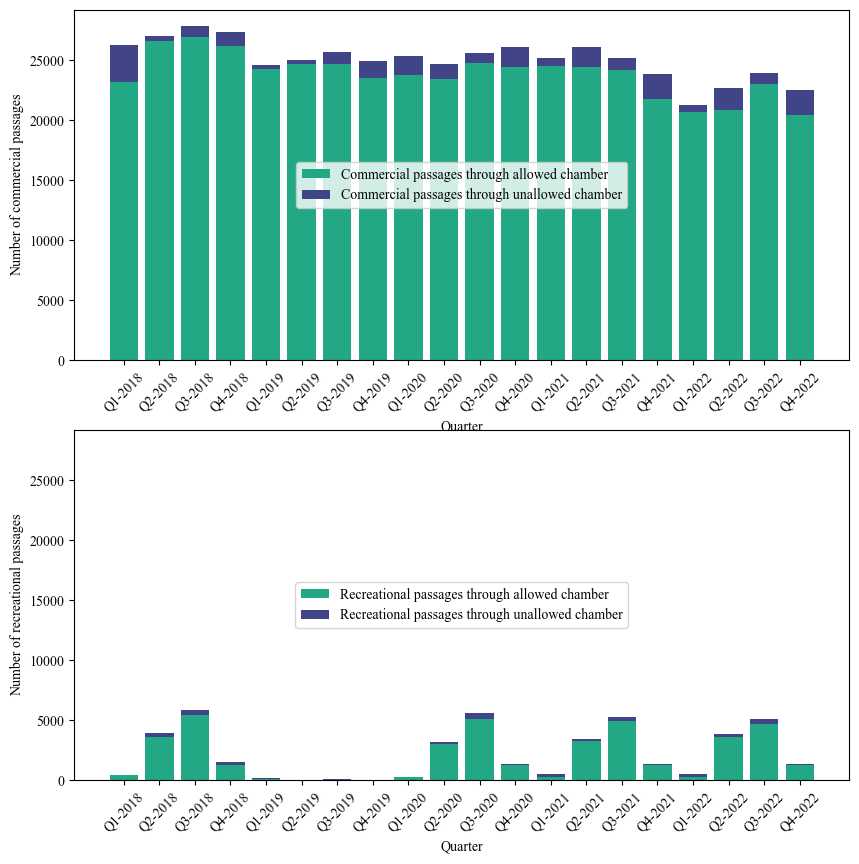

In [18]:
date_labels = [f'Q{idx.quarter}-{idx.year}' for idx in pivot_table_passages.index] 

# Create the stacked bar chart
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharey=True)

for i, plotted_type in enumerate(['commercial', 'recreational']):
    axes[i].bar(date_labels, pivot_table_passages[plotted_type][True], label=f'{plotted_type.capitalize()} passages through allowed chamber', color=viridis_colors[2])
    axes[i].bar(date_labels, pivot_table_passages[plotted_type][False], label=f'{plotted_type.capitalize()} passages through unallowed chamber', 
            bottom=pivot_table_passages[plotted_type][True], color=viridis_colors[1])
    
    # Add labels and title
    axes[i].set_xticklabels(date_labels, rotation=45) #, fontsize=8
    axes[i].set_xlabel('Quarter')
    axes[i].set_ylabel(f'Number of {plotted_type} passages')
    axes[i].legend(loc='center')


# Show the plot
plt.savefig('output/figs/input_data/passages_allowed_vs_unallowed.pdf')
plt.show()


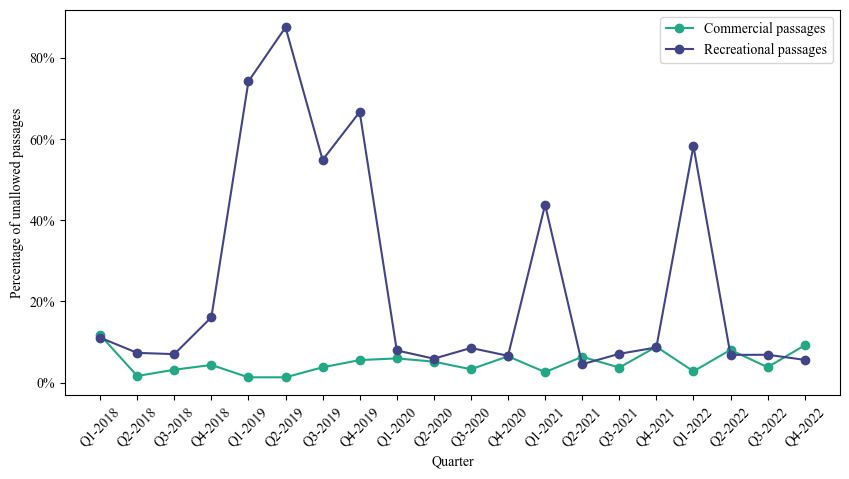

In [19]:
plt.figure(figsize=(10, 5))
for i, plotted_type in enumerate(['commercial', 'recreational']):
    plt.plot(date_labels, pivot_table_passages[plotted_type][False]/(pivot_table_passages[plotted_type][True] + pivot_table_passages[plotted_type][False]), 
            color=viridis_colors[2-i], label=f'{plotted_type.capitalize()} passages', marker="o")
plt.xticks(date_labels, rotation=45) # , fontsize=8
plt.xlabel('Quarter')
plt.ylabel('Percentage of unallowed passages')
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))
plt.legend()
plt.savefig('output/figs/input_data/percentage_unallowed.pdf')
plt.show()

<a id='passagesrenovation'></a>
### 2.3. Passages and renovation

In [23]:
pivot_table_chambers = passages.pivot_table(index=pd.Grouper(key='event_start', freq='Q'), 
                                            columns=['chamber_name', 'chamber_allowed'], aggfunc='size').fillna(0)

In [24]:
pivot_table_chambers.head()

chamber_name    Middenkolk Volkeraksluizen               \
chamber_allowed                 commercial recreational   
event_start                                               
2018-03-31                          9736.0          5.0   
2018-06-30                          8893.0         11.0   
2018-09-30                          9051.0          2.0   
2018-12-31                          8941.0         40.0   
2019-03-31                          8738.0         40.0   

chamber_name    Oostkolk Volkeraksluizen               \
chamber_allowed               commercial recreational   
event_start                                             
2018-03-31                        4324.0         32.0   
2018-06-30                        8546.0        271.0   
2018-09-30                        8706.0        406.0   
2018-12-31                        8557.0        162.0   
2019-03-31                        6356.0         64.0   

chamber_name    Sluiskolk Jachtensluis Volkeraksluizen               \
chamber_allowed                             commercial recreational   
event_start                                                           
2018-03-31                                      3084.0        369.0   
2018-06-30                                       447.0       3611.0   
2018-09-30                                       887.0       5435.0   
2018-12-31                                      1194.0       1250.0   
2019-03-31                                       325.0         48.0   

chamber_name    Westkolk Volkeraksluizen               
chamber_allowed               commercial recreational  
event_start                                            
2018-03-31                        9106.0          9.0  
2018-06-30                        9179.0          4.0  
2018-09-30                        9183.0          3.0  
2018-12-31                        8666.0         38.0  
2019-03-31                        9196.0         34.0

In [56]:
def annotate_renovation(ax, chamber, loc):
    # ax.annotate('Renovation of Gate ' + gate + ' (' + chamber + ' chamber), completed on ' + date,
    ax.annotate('Renv. \n' + chamber,
            xy=(loc, 0.2), xycoords='axes fraction',
            xytext=(-16, 10), textcoords='offset pixels',
            horizontalalignment='right',
            bbox=dict(boxstyle="round", alpha=0.8, fc="white", ec="gray"),
            verticalalignment='bottom', rotation=0, fontsize=9)

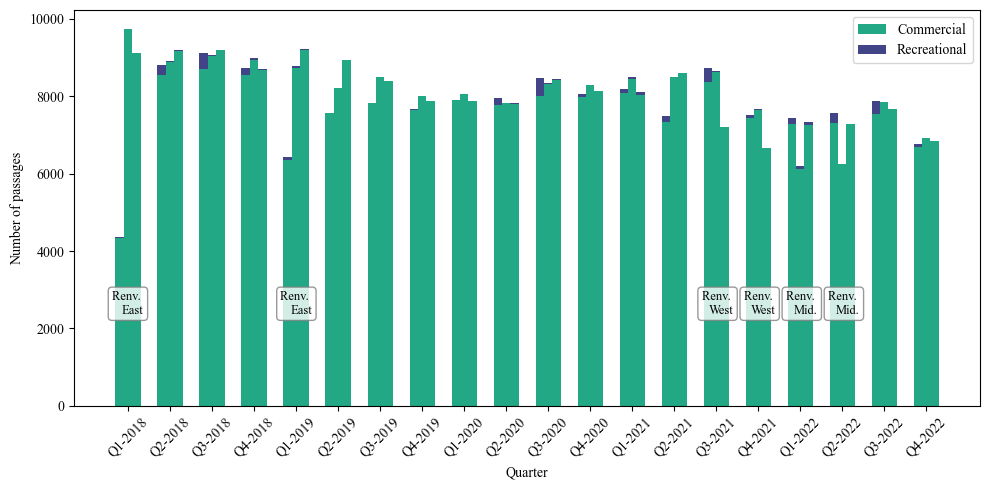

In [86]:
# Set the width of the bars
bar_width = 0.2

# Set the position of the bars on the x-axis
bar_positions = range(len(date_labels))

fig, ax = plt.subplots(figsize=(10, 5))

# Plot stacked bars for each chamber_name
for i, chamber_name in enumerate(['Oostkolk Volkeraksluizen', 'Middenkolk Volkeraksluizen', 'Westkolk Volkeraksluizen']):
    commercial_values = pivot_table_chambers[(chamber_name, 'commercial')]
    recreational_values = pivot_table_chambers[(chamber_name, 'recreational')]
    
    labels = ['Commercial', 'Recreational'] if i == 0 else [None, None, None]

    # Shift the bar positions to the middle of each cluster
    bar_positions_middle = [pos + i*bar_width for pos in bar_positions]

    ax.bar(bar_positions_middle, commercial_values, label=labels[0], width=bar_width, color=viridis_colors[2])
    ax.bar(bar_positions_middle, recreational_values, label=labels[1], width=bar_width, bottom=commercial_values, color=viridis_colors[1])

# Following two parameters are determined by trial and error
start_pt = 0.048
incr = 0.0465

for chamber, incr_multiplier in [('East', 1), ('East', 5), ('West', 15), ('West', 16), ('Mid.', 17), ('Mid.', 18)]:
    annotate_renovation(ax, chamber, start_pt + incr*incr_multiplier)

# Set x-axis labels and title
plt.xlabel('Quarter')
plt.xticks([pos + bar_width for pos in range(len(date_labels))], date_labels, rotation=45) # , fontsize=8
plt.ylabel('Number of passages')
# plt.title('Stacked Bar Chart for Each Chamber')

# Add legend for the first chamber only
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig('output/figs/input_data/number_passages.pdf')
plt.show()


Some context: 
* Doors C and A (both belonging to the East chamber) were renovated on the first quarter of the years 2018 and 2019.
* Doors G and H (both belonging to the West chamber) were renovated on the third and fourth quarter of the year 2021
* Doors D and F (both belonging to the West chamber) were renovated on the first and second quarter of the year 2022.


In [28]:
passages['week'] = passages['event_start'].dt.isocalendar().week
passages['week'].replace(to_replace=53, value=52, inplace=True)
passages.head()

,event_start,event_duration,chamber_id,chamber_name,direction_id,direction,ship_type,sk_code,year,month,day,hour,sk_shiptype,sivak_class,event_end,chamber_allowed,chamber_check,week
0,2018-01-01 00:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,1,0,M8:2,M8 (Groot Rijnschip) (CEMT V),2018-01-01 01:26:00,commercial,True,1
1,2018-01-01 00:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,1,0,M8:2,M8 (Groot Rijnschip) (CEMT V),2018-01-01 01:26:00,commercial,True,1
2,2018-01-01 00:53:00,76,2,Middenkolk Volkeraksluizen,1,Noord,2,M8,2018,1,1,0,M8:2,M8 (Groot Rijnschip) (CEMT V),2018-01-01 02:09:00,commercial,True,1
3,2018-01-01 01:26:00,36,3,Westkolk Volkeraksluizen,3,Zuid,4,M8,2018,1,1,1,M8:4,M8 (Groot Rijnschip) (CEMT V),2018-01-01 02:02:00,commercial,True,1
4,2018-01-01 02:40:00,78,2,Middenkolk Volkeraksluizen,1,Noord,2,M12,2018,1,1,2,M12:2,M12 (Rijnmax),2018-01-01 03:58:00,commercial,True,1


In [29]:
passages_in_scope = passages[passages['chamber_allowed'] !='recreational']
print(f'{len(passages_in_scope)}/{len(passages)} passages are within the scope after eliminating recreational vessels')
passages_in_scope.to_csv("data/passages_cleaned.csv")

501267/544765 passages are within the scope after eliminating recreational vessels


<a id='observingtrends'></a>
### 2.4. Observing trends in ship class characteristics

In [30]:
passages_in_scope['sivak_ship_group'] = passages_in_scope.apply(lambda x: ship_classes_dict[x['sivak_class']]['Ship Type'], axis=1)
passages_in_scope['avg_dwt'] = passages_in_scope.apply(lambda x: ship_classes_dict[x['sivak_class']]['DWT'], axis=1)
passages_in_scope['avg_area'] = passages_in_scope.apply(lambda x: ship_classes_dict[x['sivak_class']]['Area'], axis=1)
passages_in_scope['cargo_type'] = passages_in_scope.apply(lambda x: sk_ship_codes_dict[x['sk_shiptype']]['cargo_type'], axis=1)
passages_in_scope['cargo_subtype'] = passages_in_scope.apply(lambda x: sk_ship_codes_dict[x['sk_shiptype']]['cargo_subtype'], axis=1)
passages_in_scope.head()

,event_start,event_duration,chamber_id,chamber_name,direction_id,direction,ship_type,sk_code,year,month,...,sivak_class,event_end,chamber_allowed,chamber_check,week,sivak_ship_group,avg_dwt,avg_area,cargo_type,cargo_subtype
0,2018-01-01 00:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,...,M8 (Groot Rijnschip) (CEMT V),2018-01-01 01:26:00,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Tank
1,2018-01-01 00:33:00,53,3,Westkolk Volkeraksluizen,1,Noord,2,M8,2018,1,...,M8 (Groot Rijnschip) (CEMT V),2018-01-01 01:26:00,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Tank
2,2018-01-01 00:53:00,76,2,Middenkolk Volkeraksluizen,1,Noord,2,M8,2018,1,...,M8 (Groot Rijnschip) (CEMT V),2018-01-01 02:09:00,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Tank
3,2018-01-01 01:26:00,36,3,Westkolk Volkeraksluizen,3,Zuid,4,M8,2018,1,...,M8 (Groot Rijnschip) (CEMT V),2018-01-01 02:02:00,commercial,True,1,MotorVessel,2831.0,1199.92,Tank,Gas
4,2018-01-01 02:40:00,78,2,Middenkolk Volkeraksluizen,1,Noord,2,M12,2018,1,...,M12 (Rijnmax),2018-01-01 03:58:00,commercial,True,1,MotorVessel,6056.0,2201.62,Tank,Tank


In [31]:
pivot_table_shipclasses = passages_in_scope.pivot_table(index=pd.Grouper(key='event_start', freq='Q'), 
                                            columns=['cargo_type'], aggfunc='size').fillna(0)
pivot_table_shipclasses['Other Cargo and Container'] = pivot_table_shipclasses[['Bulk','Cargo', 'Container', 'Freight']].sum(axis=1)
pivot_table_shipclasses.head()

cargo_type,Bulk,Cargo,Container,Freight,Tank,Other Cargo and Container
event_start,,,,,,
2018-03-31,1.0,535.0,193.0,12546.0,12476.0,13275.0
2018-06-30,0.0,597.0,183.0,12807.0,12495.0,13587.0
2018-09-30,0.0,593.0,221.0,13107.0,13110.0,13921.0
2018-12-31,0.0,737.0,211.0,12595.0,12982.0,13543.0
2019-03-31,1.0,591.0,198.0,11609.0,11674.0,12399.0


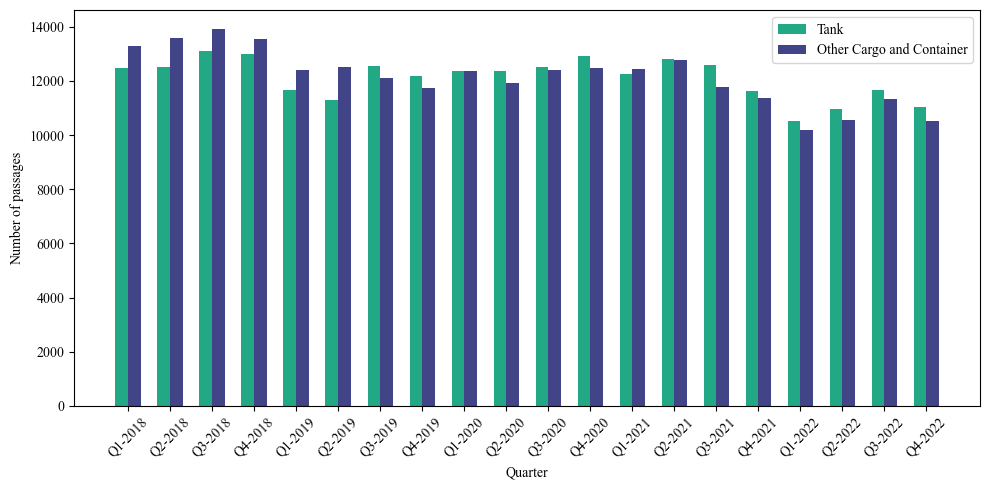

In [32]:
date_year_labels = pivot_table_shipclasses.index.year


# Set the width of the bars
bar_width = 0.3

# Set the position of the bars on the x-axis
bar_positions = range(len(date_labels))

plt.figure(figsize=(10, 5))

plotted_list = ['Tank', 'Other Cargo and Container'] # ['Bulk', 'Cargo', 'Container', 'Freight', 'Tank']

# Plot stacked bars for each chamber_name
for i, plotted_type in enumerate(plotted_list):
    plotted_values = pivot_table_shipclasses[plotted_type]

    # Shift the bar positions to the middle of each cluster
    bar_positions_middle = [pos + (i+0.5)*bar_width for pos in bar_positions]

    plt.bar(bar_positions_middle, plotted_values, label=plotted_type, width=bar_width, color=viridis_colors[2-i])

# Set x-axis labels and title
plt.xlabel('Quarter')
plt.xticks([pos + bar_width for pos in range(len(date_labels))], date_labels, rotation=45) # , fontsize=8
plt.ylabel('Number of passages')
# plt.title('Stacked Bar Chart for Each Chamber')

# Add legend for the first chamber only
plt.legend()

# Show the plot
plt.tight_layout()

# Show the plot
plt.savefig('output/figs/input_data/tank_vs_other.pdf')
plt.show()


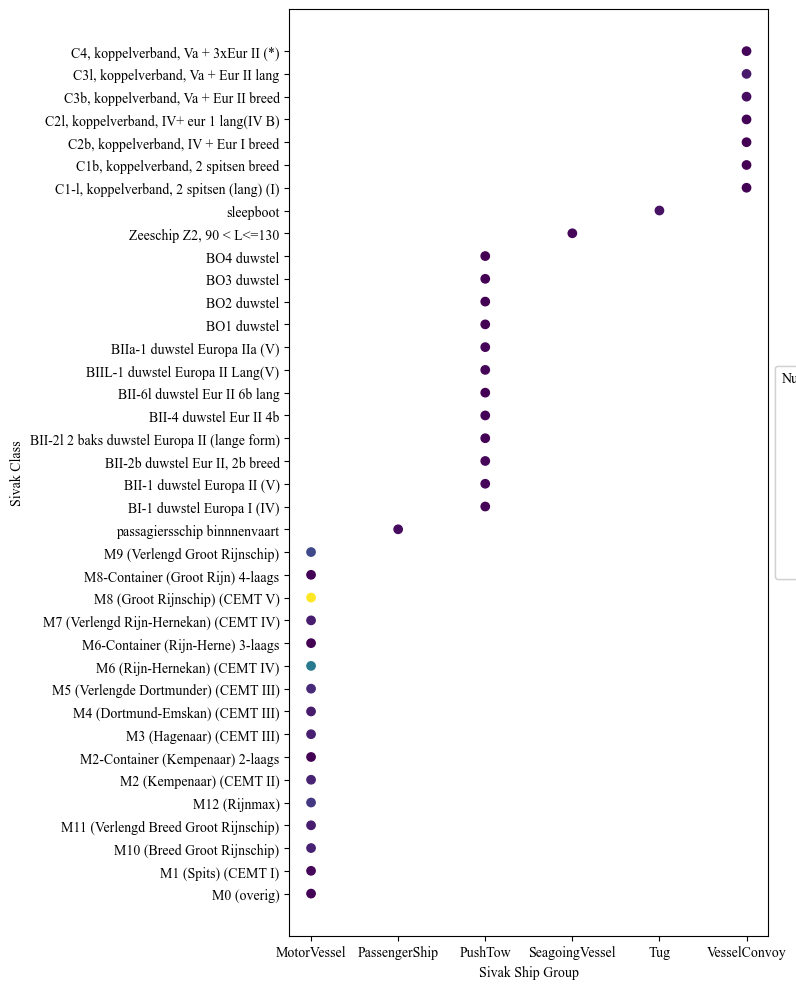

In [33]:
ship_sk_code_pair_summary = plot_scatter_of_pair(passages_in_scope, "sivak_ship_group", "sivak_class", "output/figs/input_data/ship_type_sk_code.pdf", figsize=(8, 10))

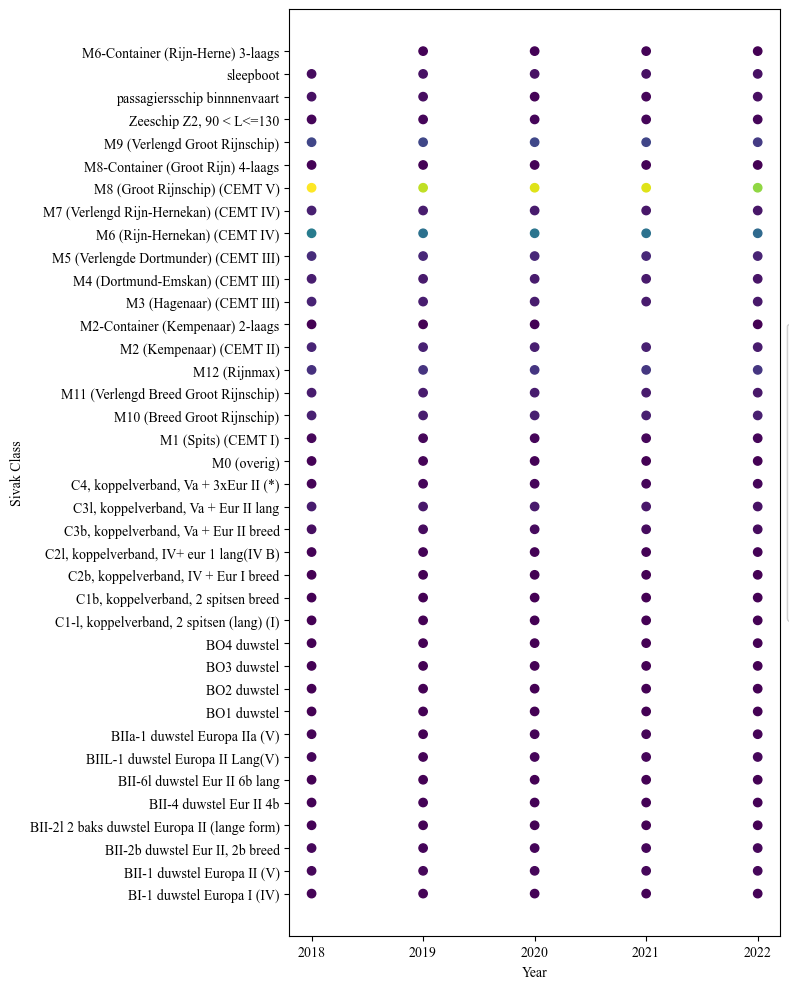

In [34]:
ship_year_pair_summary = plot_scatter_of_pair(passages_in_scope, "year", "sivak_class", "output/figs/input_data/year_sk_code.pdf", figsize=(8, 10))

In [35]:
ship_year_pair_pivot = pd.pivot_table(ship_year_pair_summary, values='size', index='sivak_class', columns='year').fillna(0)
ship_year_pair_pivot.head()

year,2018,2019,2020,2021,2022
sivak_class,,,,,
BI-1 duwstel Europa I (IV),461.0,409.0,300.0,218.0,244.0
BII-1 duwstel Europa II (V),634.0,671.0,644.0,740.0,760.0
"BII-2b duwstel Eur II, 2b breed",750.0,585.0,525.0,581.0,714.0
BII-2l 2 baks duwstel Europa II (lange form),225.0,197.0,126.0,104.0,126.0
BII-4 duwstel Eur II 4b,259.0,211.0,187.0,207.0,215.0


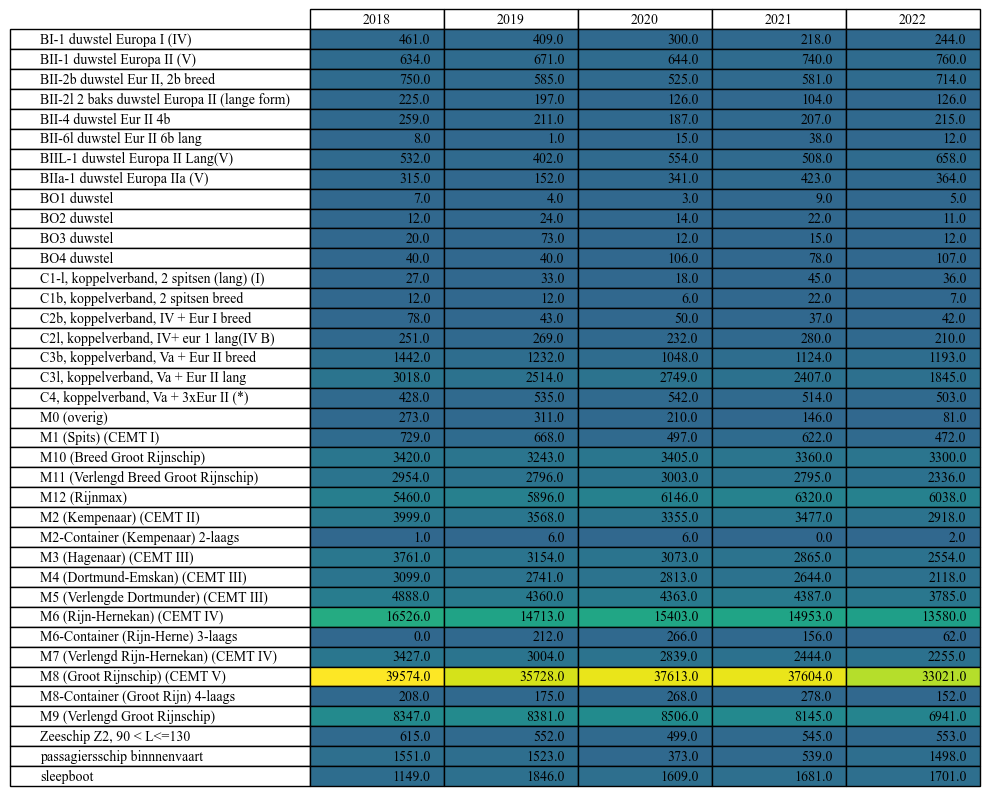

In [36]:
palette_adjuster = ship_year_pair_pivot.max().max()/2

vals = np.around(ship_year_pair_pivot.values,2)
norm = plt.Normalize(vals.min()- palette_adjuster, vals.max()+1)
colours = plt.cm.viridis(norm(vals))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])

table=plt.table(cellText=vals, rowLabels=ship_year_pair_pivot.index, colLabels=ship_year_pair_pivot.columns, 
                    colWidths = [0.2]*vals.shape[1], loc='center', 
                    cellColours=colours)
table.set_fontsize(10)

plt.tight_layout()
plt.savefig('output/figs/input_data/ship_type_number_arrivals_table.pdf')
plt.show()


In [68]:
def calculated_total_stat(df, ship_classes_dict, stat_name):
    # df should have a column sivak_class
    new_col_name = 'total_' + stat_name
    df[new_col_name] = df.apply(lambda x: x[0]*ship_classes_dict[x['sivak_class']][stat_name], axis=1)
    return df

In [77]:
def calculated_per_ship_stat(df, stat_name):
    # df should have number of passages as df[0]
    new_col_name = stat_name + '_per_ship'
    total_col_name  = 'total_' + stat_name
    df[new_col_name] = df[total_col_name]/df[0]
    return df

In [84]:
ships_yearly = passages_in_scope.groupby(['year']).agg({'event_duration': 'std'}).reset_index()
freq_selection = 'year' # 'quarter

ships_yearly = pd.DataFrame(passages_in_scope.groupby([freq_selection, 'sivak_class']).size()).reset_index()
for stat_name in ['DWT', 'LOA', 'Width']:
    ships_yearly = calculated_total_stat(ships_yearly, ship_classes_dict, stat_name)
ships_yearly['total_area_(km2)'] = ships_yearly['total_LOA'] * ships_yearly['total_Width']

yearly_statistics = pd.DataFrame(ships_yearly.groupby([freq_selection]).sum()).reset_index()
for stat_name in ['DWT', 'LOA', 'Width']:
    yearly_statistics = calculated_per_ship_stat(yearly_statistics, stat_name, 0)
yearly_statistics['area_per_ship'] = yearly_statistics['total_area_(km2)']/yearly_statistics[0]*1e6
yearly_statistics['avg_passage_time'] = list(passages_in_scope.groupby(['year']).agg({'event_duration': 'mean'}).event_duration)

yearly_statistics.columns = ['Year', 'Number of passages', 'Total DWT', 'Total LOA (m)', 'Total width (m)', 'Total area (km2)',
                             'DWT per ship', 'LOA per ship (m)', 'Width per ship (m)', 'Area per ship (m2)', 'Avg passage time (min)']

yearly_statistics_normalized = yearly_statistics.divide(yearly_statistics.loc[0]) * 100
yearly_statistics_normalized.Year = yearly_statistics.Year
yearly_statistics_normalized.head()

,Year,Number of passages,Total DWT,Total LOA (m),Total width (m),Total area (km2),DWT per ship,LOA per ship (m),Width per ship (m),Area per ship (m2),Avg passage time (min)
0,2018,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
1,2019,92.427650,93.228759,92.455486,92.789314,83.130935,100.866742,100.030117,100.391295,89.941631,88.841480
2,2020,93.750230,96.634876,94.783400,94.560865,91.322310,103.076948,101.102045,100.864675,97.410224,86.061557
3,2021,92.472811,95.481266,93.238512,93.549789,90.331753,103.253340,100.828029,101.164643,97.684662,88.253937
4,2022,83.346544,85.883423,83.701025,84.926596,70.512384,103.043773,100.425310,101.895762,84.601449,87.994750


In [38]:
market_insight_normalized =  pd.read_csv("data/market_insight_normalized.csv", index_col=0)
market_insight_normalized

,Dry bulk transport in NL (Mt),Liquid bulk transport in NL (Mt),Container transport in NL (Mt),Freight rate in Lower Rhine region
2018,100.000000,100.000000,100.000000,100.0
2019,92.802303,106.360424,95.112782,81.5
2020,87.140115,106.360424,95.864662,57.4
2021,92.994242,110.954064,101.879699,54.0
2022,95.201536,109.010601,95.112782,117.0


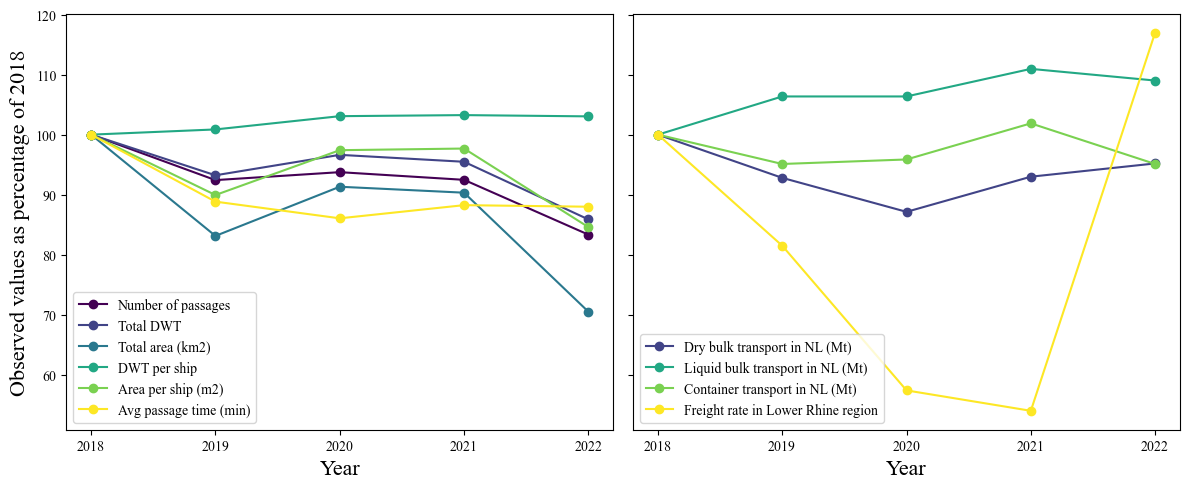

In [85]:
# Credit: https://cmdlinetips.com/2019/10/how-to-make-a-plot-with-two-different-y-axis-in-python-with-matplotlib/

fig,ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for i, plotted_column in enumerate(['Number of passages', 'Total DWT', 'Total area (km2)',
                             'DWT per ship', 'Area per ship (m2)', 'Avg passage time (min)']):
    ax[0].plot(yearly_statistics_normalized.Year, yearly_statistics_normalized[plotted_column], color=viridis_colors_6[i], marker="o", label=plotted_column)

ax[0].legend(ncol=1, loc='lower left')
ax[0].set_xticks(yearly_statistics_normalized.Year)
ax[0].set_xlabel('Year', fontsize=16)
ax[0].set_ylabel('Observed values as percentage of 2018', fontsize=16)


for i, plotted_column in enumerate(market_insight_normalized.columns):
    ax[1].plot(market_insight_normalized.index, market_insight_normalized[plotted_column], color=viridis_colors[i+1], marker="o", label=plotted_column)

ax[1].legend(ncol=1, loc='lower left')
ax[1].set_xticks(yearly_statistics_normalized.Year)
ax[1].set_xlabel('Year', fontsize=16)

plt.tight_layout()
plt.savefig('output/figs/input_data/change_over_time.pdf')
plt.show()


<a id='passagetimes'></a>
### 2.5. Passage times

In [40]:
passages_in_scope.describe()

,event_duration,chamber_id,direction_id,ship_type,year,month,day,hour,week,avg_dwt,avg_area
count,501267.000000,501267.000000,501267.000000,501267.000000,501267.000000,501267.000000,501267.000000,501267.000000,501267.0,501267.000000,501267.000000
mean,33.983288,2.120882,2.015423,4.072141,2019.928004,6.518857,15.715090,12.718451,26.574373,2702.263887,1182.682357
std,19.399887,0.899142,0.999882,8.944457,1.408001,3.418295,8.769645,6.064193,14.898915,1564.432689,573.082433
min,0.000000,1.000000,1.000000,1.000000,2018.000000,1.000000,1.000000,0.000000,1.0,0.000000,117.600000
25%,24.000000,1.000000,1.000000,1.000000,2019.000000,4.000000,8.000000,8.000000,14.0,1362.000000,743.568800
50%,34.000000,2.000000,3.000000,2.000000,2020.000000,7.000000,16.000000,13.000000,27.0,2831.000000,1199.920000
75%,43.000000,3.000000,3.000000,2.000000,2021.000000,9.000000,23.000000,18.000000,40.0,3699.000000,1446.640000
max,4152.000000,4.000000,3.000000,90.000000,2022.000000,12.000000,31.000000,23.000000,52.0,15633.000000,6020.760000


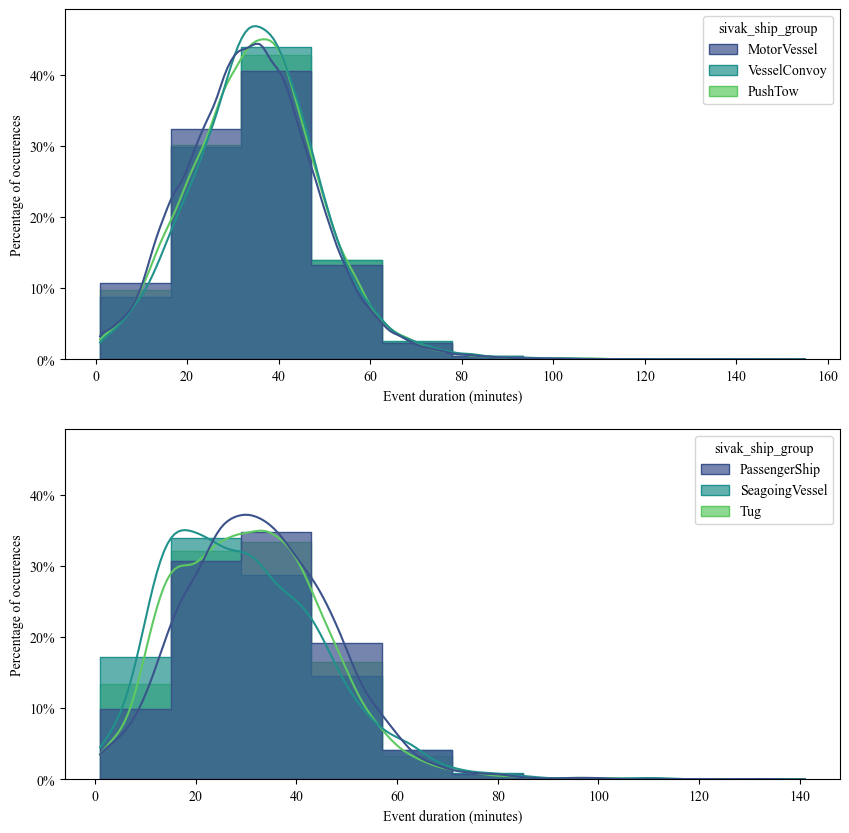

In [41]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharey=True)
passages_without_outliers= passages_in_scope.loc[eliminate_outliers_IQR(passages_in_scope.event_duration, 6).index]
passages_without_outliers= passages_without_outliers[passages_without_outliers['event_duration']!=0]

for i, plotted_group in enumerate([['MotorVessel', 'VesselConvoy', 'PushTow'], ['PassengerShip', 'SeagoingVessel', 'Tug']]):

    sns.histplot(data=passages_without_outliers[passages_without_outliers['sivak_ship_group'].isin(plotted_group)], 
                x='event_duration', hue='sivak_ship_group', kde=True, alpha=0.7, bins=10, stat='percent', common_norm=False, 
                palette='viridis',  element="step", ax=axes[i])
    # plt.hist(eliminate_outliers_IQR(passages_in_scope.event_duration, 6), bins = 20)
    axes[i].set_xlabel("Event duration (minutes)") # , fontsize=24
    axes[i].set_ylabel("Percentage of occurences") # , fontsize=24
    y_vals = axes[i].get_yticks()
    axes[i].set_yticklabels(['{:,.0%}'.format(y/100) for y in y_vals])
    axes[i].tick_params() # labelsize=16

plt.savefig("output/figs/input_data/eventdur_hist_per_ship_group.pdf")

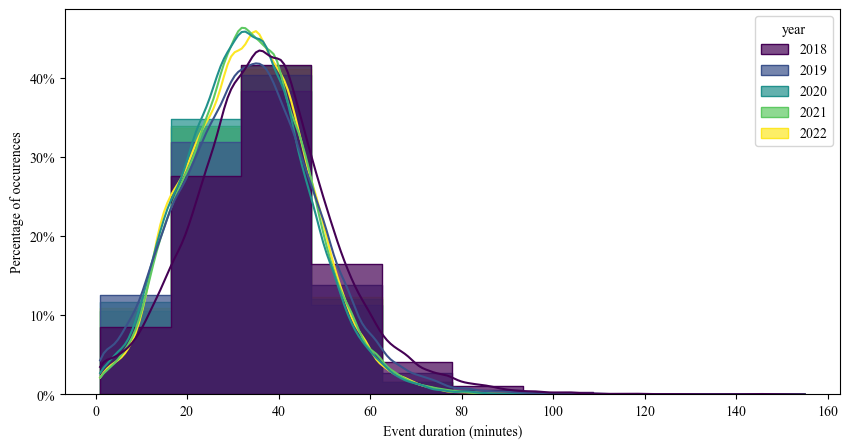

In [42]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=passages_without_outliers, 
            x='event_duration', hue='year', kde=True, alpha=0.7, bins=10, stat='percent', common_norm=False, 
            palette='viridis',  element="step", ax=ax)
# plt.hist(eliminate_outliers_IQR(passages_in_scope.event_duration, 6), bins = 20)
ax.set_xlabel("Event duration (minutes)") # , fontsize=24
ax.set_ylabel("Percentage of occurences") # , fontsize=24
y_vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(y/100) for y in y_vals])
ax.tick_params() # labelsize=16
plt.savefig("output/figs/input_data/eventdur_hist_per_year.pdf")

In [43]:
passages_in_scope.event_duration.mean()

33.98328834732787

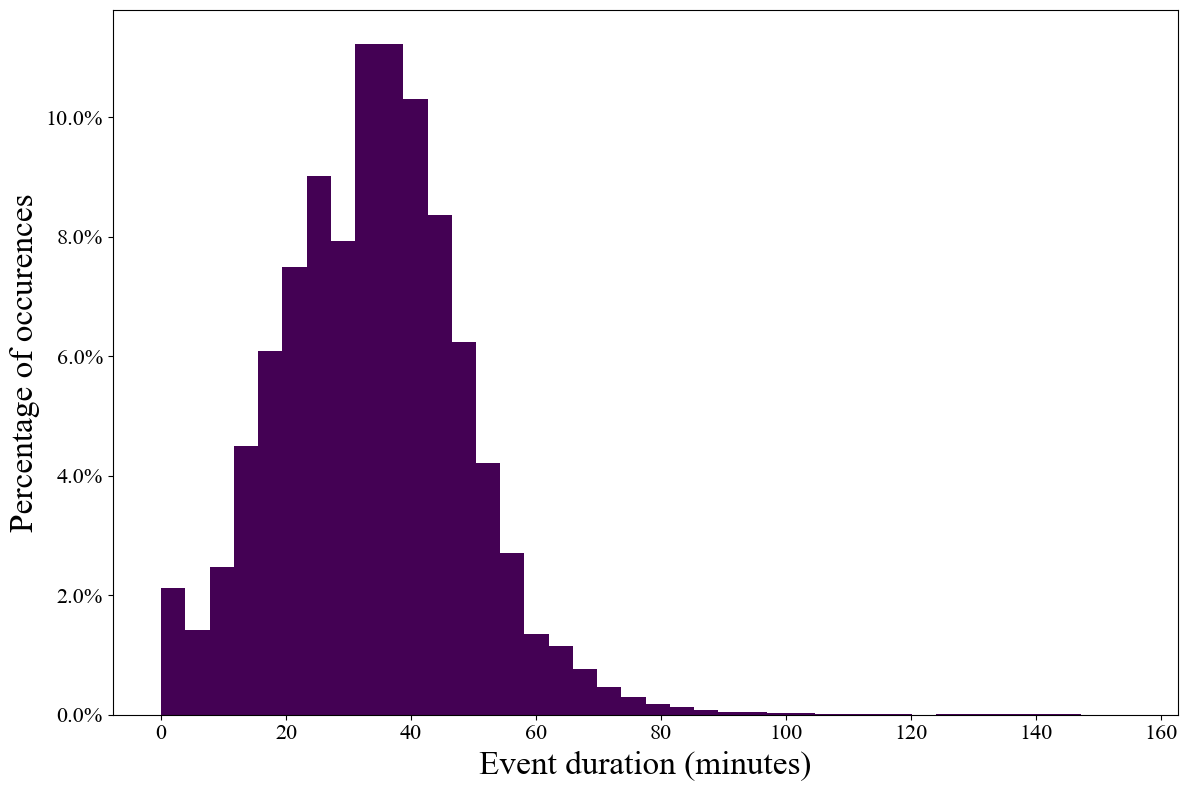

In [44]:
fig, ax = plt.subplots(figsize=(12,8))
df = eliminate_outliers_IQR(passages_in_scope.event_duration, 6)
plt.hist(df, weights=np.ones(len(df)) / len(df), bins = 40, color=viridis_colors[0])
ax.set_xlabel("Event duration (minutes)", fontsize=24)
ax.set_ylabel("Percentage of occurences", fontsize=24)
ax.tick_params(labelsize=16)
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))

plt.tight_layout()
plt.savefig("output/figs/input_data/eventdur_hist.pdf")
plt.show()

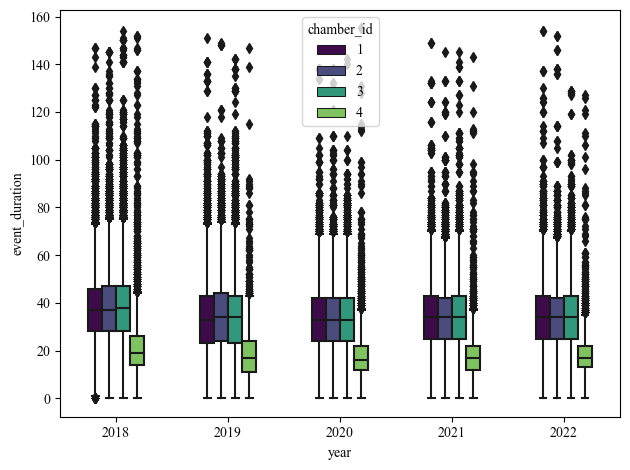

In [45]:
sns.boxplot(y='event_duration', x='year', hue='chamber_id', data=passages.loc[list(df.index),:], palette=viridis_colors, width=0.5)
ax.set_xlabel("Event duration (minutes)", fontsize=24)
ax.set_ylabel("Year", fontsize=24)
plt.tight_layout()
plt.savefig("output/figs/input_data/passage_times_boxplots.pdf")
plt.show()


<a id='lockages'></a>
### 2.6. Lockages

In [46]:
grouped_by_start = passages_in_scope[["chamber_id", "event_start", "direction_id", "sk_code"]]
grouped_by_start = grouped_by_start.groupby(by=["chamber_id", "event_start", "direction_id"], as_index = False)
df = grouped_by_start.count()

In [47]:
# To fill out the empty lockages, we will go through every row of the data frame
# if the chamber id is the same as the next row (chamber 1 and chamber 1), and the direction is the same (North and North)
# it means that there was one South in the middle that we aren't able to catch up due to not having any ship registered
# we will add this levelling
print(len(df))
for i in tqdm(range(len(df)-1)): 
    if (df.loc[i, 'chamber_id'] == df.loc[i+1, 'chamber_id']) and (df.loc[i, 'direction_id'] == df.loc[i+1, 'direction_id']):
        df = df.append(pd.DataFrame(
            {
                "chamber_id":[df.loc[i, 'chamber_id']], 
                'event_start':[df.loc[i+1, 'event_start'] - timedelta(minutes=10)], 
                'direction':[4-df.loc[i, 'direction_id']],
                'sk_code': [0],
                }), ignore_index = True
            )
print(len(df))

212831


100%|██████████| 212830/212830 [04:08<00:00, 855.78it/s] 

244178


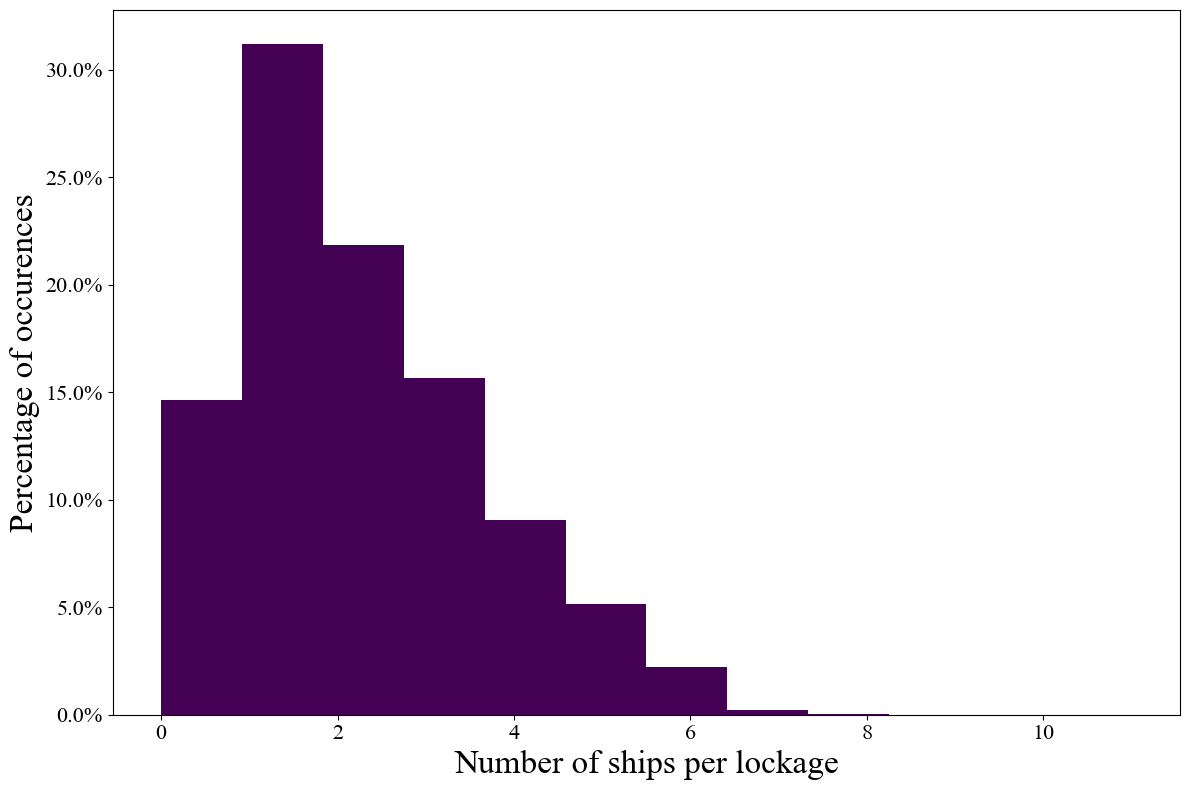

In [48]:
fig, ax = plt.subplots(figsize=(12,8))
entries, edges, _ = plt.hist(df.sk_code, weights=np.ones(len(df)) / len(df), bins = 12, color=viridis_colors[0])
# bin_centers = 0.5 * (edges[:-1] + edges[1:])
# plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries)/10, capsize=4, fmt='r.')
ax.set_xlabel("Number of ships per lockage", fontsize=24)
ax.set_ylabel("Percentage of occurences", fontsize=24)
ax.tick_params(labelsize=16)
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1))
plt.tight_layout()
plt.savefig("output/figs/input_data/number_ship_per_lockage_hist.pdf")
plt.show()

In [49]:
df['year'] = pd.DatetimeIndex(df.event_start).year
grouped_df = pd.DataFrame(df.groupby(['year', 'sk_code']).size()).reset_index().rename(columns={0: 'observations'})
grouped_df['cluster'] = grouped_df.apply(lambda x: 
                                           '0' if x['sk_code']==0
                                           else '1' if x['sk_code']==1
                                                else '2' if x['sk_code']==2
                                                else '3-6' if (x['sk_code']>2 and x['sk_code']<7) else 
                                                '7<', axis=1)
grouped_df = pd.pivot_table(grouped_df, values = 'observations', index=['year'], 
                            columns=['cluster'], aggfunc=np.sum).reset_index()[['0','1','2','3-6','7<']]
grouped_df = grouped_df.div(grouped_df.sum(axis=1), axis=0)
grouped_df.index = range(2018,2023)
grouped_df.to_csv('output/tables/number_ship_per_lockage_hist.csv')
grouped_df

cluster,0,1,2,3-6,7<
2018,0.130116,0.302805,0.216269,0.347391,0.003419
2019,0.150399,0.300715,0.222052,0.324559,0.002275
2020,0.144421,0.321123,0.222135,0.310974,0.001347
2021,0.142484,0.310788,0.214762,0.329293,0.002673
2022,0.166745,0.326108,0.216597,0.288897,0.001652


<a id='malfunctions'></a>
# 3. Malfunctions

In [51]:
malfunctions =  pd.read_csv("data/number_of_malfunctions.csv", index_col=0)
malfunctions.head()

,Number of malfunctions,Number of malfunctions HVVOS
Period,,
Q1-2017,50,86
Q2-2017,42,72
Q3-2017,43,74
Q4-2017,29,50
Q1-2018,46,79


In [52]:
malfunctions.index[::5]

Index(['Q1-2017', 'Q2-2018', 'Q3-2019', 'Q4-2020', 'Q1-2022'], dtype='object', name='Period')

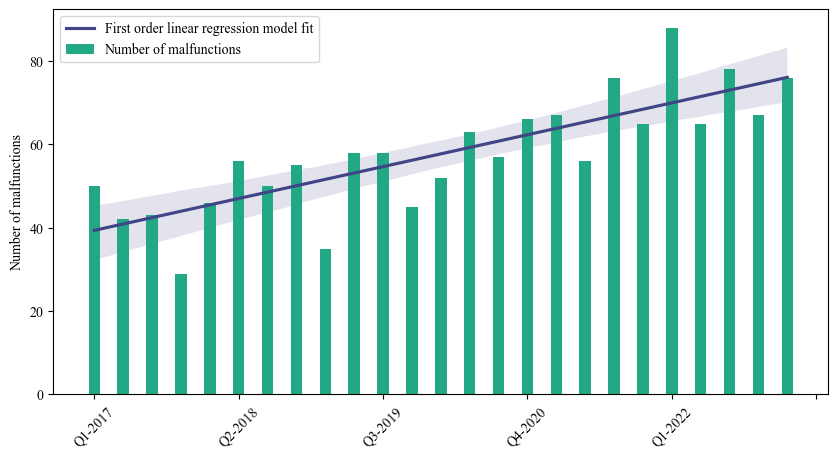

In [53]:
labels = ['Q1-2017', 'Q1-2017', 'Q2-2018', 'Q3-2019', 'Q4-2020', 'Q1-2022']

fig, ax = plt.subplots(figsize=(10, 5))
sns.regplot(ax=ax, x=np.array(range(len(malfunctions))), y=malfunctions['Number of malfunctions'], color=viridis_colors[1], scatter=False, 
            label='First order linear regression model fit', order=1)

ax.bar(x=np.array(range(len(malfunctions))), height=malfunctions['Number of malfunctions'], label='Number of malfunctions', width=0.4, color=viridis_colors[2])
# ax.set_xticklabels(malfunctions.index, rotation=45, fontsize=8)
ax.set_xticklabels(labels, rotation=45)  # Set the custom tick labels with rotation
plt.legend()
plt.savefig('output/figs/input_data/no_malfunctions.pdf')
plt.show()

In [54]:
x=np.array(range(len(malfunctions))).reshape(-1, 1)
y=malfunctions['Number of malfunctions']


model = LinearRegression().fit(x, y)
r_sq = model.score(x, y)
print(f"coefficient of determination: {r_sq}")
print(f"slope: {4*model.coef_}")

coefficient of determination: 0.6557086342716287
slope: [6.12]


In [55]:
4*model.coef_/malfunctions['Number of malfunctions'].mean()

array([0.10602911])